# 2주차 커리큘럼

## 목차

* **pytorch의 이미지 배열 특징**

* **CNN 구현 및 이해**

* **pytorch의 주요 학습 메커니즘**

# pytorch의 이미지 배열 특징

일반적으로 이미지는 3차원 배열로 나타냄.<br/>
이런 이미지가 여러개인 이미지 묶음은 4차원.

일반적으로 3차원 이미지는 다음과 같이 last channel 형태를 가짐.

<br/>

$$(Height, Weight, Channel)$$

<br/><br/>

하지만, 파이토치에서 3차원 이미지는 first channel이라고 가정.

<br/>

$$(Channel, Height, Weight)$$

<br/><br/>

1주차에서 배운 tensor의 permute()라는 메서드를 이용하여 이 문제를 해결.

## 데이터 불러오기

1주차에서 했던 내용 그대로 진행

In [ ]:
from google.colab import drive

# 자신의 google drive에 연결합니다.
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/h.2026_예비대학/dogs-vs-cats.zip"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/h.2026_예비대학/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip -q "/content/train.zip"

In [ ]:
!pip install torchinfo

In [ ]:
import os # os(Operating System)모듈은 파이썬에서 운영체제에 쉽게 접근할 수 있도록 해주는 모듈입니다.
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

image_paths = []
labels = [] # 실제 정답 값

for dirname, _, filenames in os.walk("/content/train"):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        image_paths.append(image_path)

        if 'cat' in image_path:
            labels.append('cat')
        elif 'dog' in image_path:
            labels.append('dog')
        else:
            labels.append('None')

cat_dog_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
})

label_to_id = {
    'cat': 0,
    'dog': 1
}

id_to_label = {
    0: 'cat',
    1: 'dog'
}

cat_dog_df['label'] = cat_dog_df['label'].map(label_to_id)
train_df, test_df = train_test_split(cat_dog_df, stratify=cat_dog_df['label'], test_size=0.1)
train_df, val_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.2)
test_df.drop(['label'], axis=1, inplace=True)

train_df.shape, val_df.shape, test_df.shape

((18000, 2), (4500, 2), (2500, 1))

## last channel 이미지를 first channel 이미지로 바꾸기

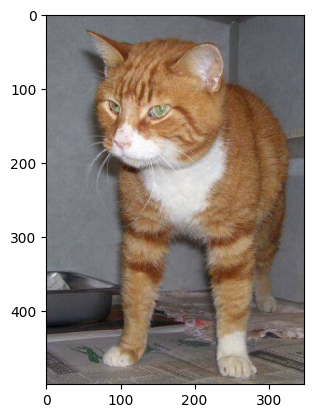

In [ ]:
import torch

import matplotlib.pyplot as plt
import cv2

# 이미지 배열 불러오기
image = cv2.cvtColor(cv2.imread(train_df['image_path'].values[0]), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
# 현재 이미지는 3차원이며, last channel 이미지
print(f"현재 이미지 shape: {image.shape}")

# 현재 이미지 유형은 넘파이 "배열"임.
print(f"현재 이미지 유형: {type(image)}")

현재 이미지 shape: (499, 348, 3)
현재 이미지 유형: <class 'numpy.ndarray'>


In [ ]:
# 배열을 텐서로 변환
tensor_image = torch.tensor(image)

# permute()메서드를 통해 last channel -> first channel로 변경
tensor_image = tensor_image.permute(2, 0, 1)

print(f"변환된 이미지 텐서 shape: {tensor_image.shape}")
print(f"tensor image 유형: {type(tensor_image)}")

변환된 이미지 텐서 shape: torch.Size([3, 499, 348])
tensor image 유형: <class 'torch.Tensor'>


In [ ]:
# shape가 어떻게 바뀌었는지 확인
print(f"원본 이미지: {image.shape}")
print(f"변형 이미지: {tensor_image.shape}")

원본 이미지: (499, 348, 3)
변형 이미지: torch.Size([3, 499, 348])


## 3차원 이미지를 4차원 이미지로 만들기

일반적으로 CNN 모델은 단일 이미지가 아닌 다수의 이미지가 들어온다고 가정하므로 1개의 이미지라도 4차원으로 바꿔줘야 함.<br/>
*이때, 이미지 개수를 배치(batch)라고 함.*

<br/><br/>

$$(Channel, Height, Width) → (Batch, Channel, Height, Width)$$

<br/><br/>

$$(3, 224, 224) → (1, 3, 224, 224)$$

tensor의 unsqueeze() 메서드를 통해 해결 가능

In [ ]:
# 앞에서 만든 tensor_image를 한 차원 더 늘리기
unsqueezed_tensor_image = tensor_image.unsqueeze(0)

print(f"원본 이미지 shape: {tensor_image.shape}")
print(f"4차원이 된 이미지 shape: {unsqueezed_tensor_image.shape}")

원본 이미지 shape: torch.Size([3, 499, 348])
4차원이 된 이미지 shape: torch.Size([1, 3, 499, 348])


# CNN구현 및 이해

파이토치에서는 Convolutional Layer를 nn.Conv2d()라는 메서드로 구현 가능

공식문서에도 나와있듯이 Conv2d는 입력으로 4차원 텐서를 기대.

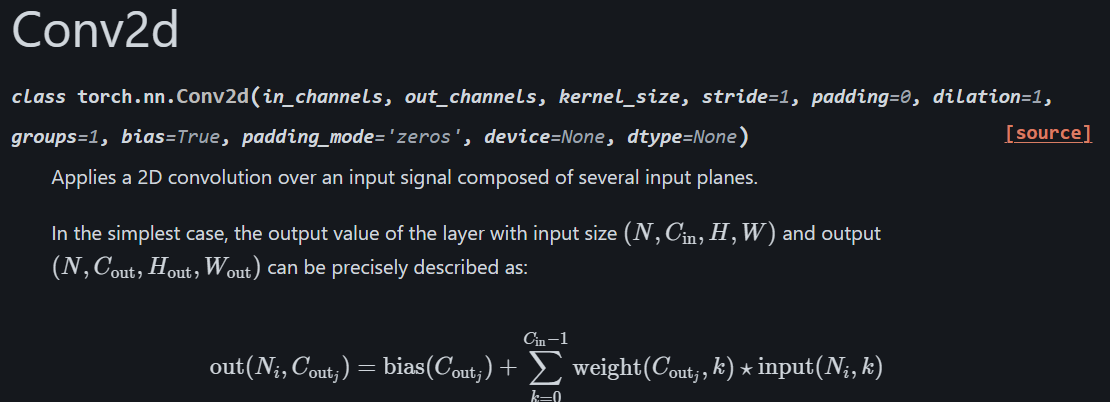

## nn.Conv2d()

In [ ]:
import torch.nn as nn

tensor_image = torch.tensor(image, dtype=torch.float32)
tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)

# nn.Conv2d()메서드를 활용하여 Convolutional Layer를 만들 수 있음.
# in_channels는 무.조.건 앞 이미지(혹은 feature map)의 차원 수를 따라가야함. 안 그러면 에러남(계산 불가!!!).
conv_layer1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
feature_map = conv_layer1(tensor_image)

In [ ]:
print(f"input shape: {tensor_image.shape}")

# output shape를 보면 channel이 10으로 변경됨.
# 이는 nn.Conv2d()메서드에서 out_channels=10으로 설정했기 때문.
print(f"output shape: {feature_map.shape}")

input shape: torch.Size([1, 3, 499, 348])
output shape: torch.Size([1, 10, 497, 346])


### stride 설정

stride는 필터가 이동하는 step을 의미

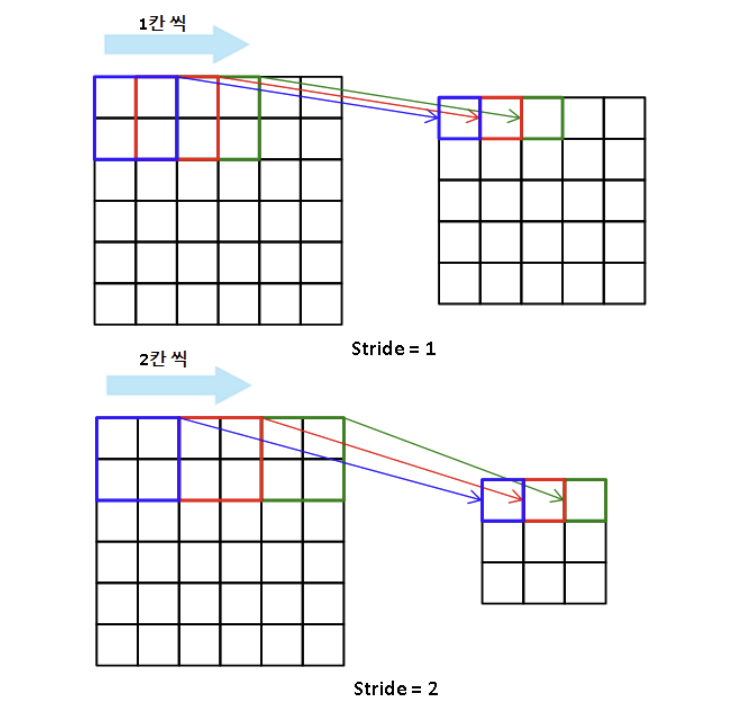

In [ ]:
tensor_image = torch.tensor(image, dtype=torch.float32)
tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)

# stride가 1인 경우, 필터가 1칸씩 이동
conv_layer_with_stride1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1)
feature_map_stride1 = conv_layer_with_stride1(tensor_image)

# stride가 2인 경우, 필터가 2칸씩 이동(당연히 나오는 이미지 크기가 더 작아짐)
conv_layer_with_stride2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=2)
feature_map_stride2 = conv_layer_with_stride2(tensor_image)

print(f"stride가 1인 경우: {feature_map_stride1.shape}")
print(f"stride가 2인 경우: {feature_map_stride2.shape}")

stride가 1인 경우: torch.Size([1, 10, 497, 346])
stride가 2인 경우: torch.Size([1, 10, 249, 173])


### padding 설정

padding은 이미지의 상하좌우에 특정 값을 추가

padding을 적용하면 기존 이미지의 크기 손실을 막을 수 있음. *default=0*

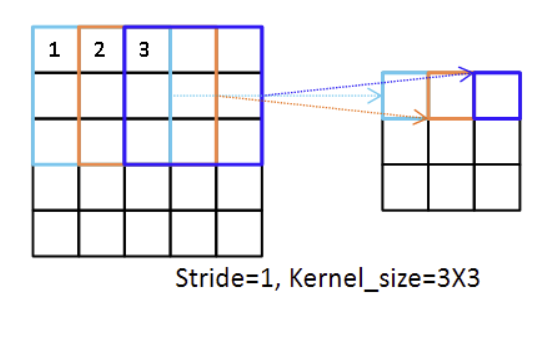

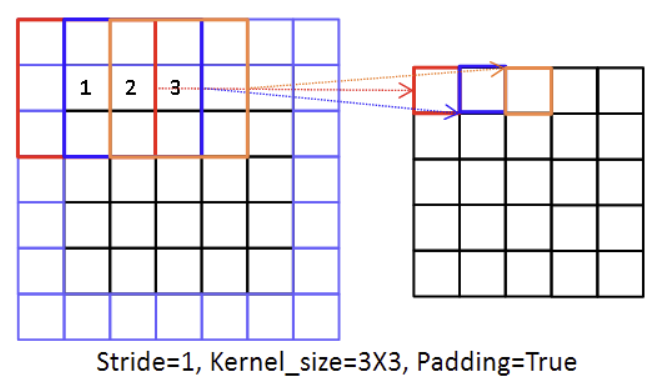

In [ ]:
tensor_image = torch.tensor(image, dtype=torch.float32)
tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)

# padding=1인 경우
conv_layer_with_padding1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
feature_map_padding1 = conv_layer_with_padding1(tensor_image)

# padding=2인 경우
conv_layer_with_padding2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=2)
feature_map_padding2 = conv_layer_with_padding2(tensor_image)

print(f"padding=1인 경우: {feature_map_padding1.shape}")
print(f"padding=2인 경우: {feature_map_padding2.shape}")

padding=1인 경우: torch.Size([1, 10, 499, 348])
padding=2인 경우: torch.Size([1, 10, 501, 350])


### nn.MaxPool2d( )

풀링은 패딩과 반대되는 개념으로 Feautre Map을 일정 수용장에서 다운 샘플링

그 중에서도 MaxPooling은 특정 kernel_size에서 가장 큰 값만 가지고 옴.

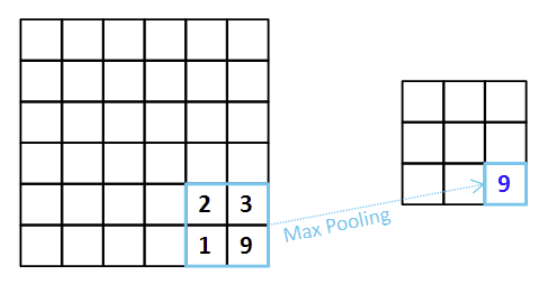

In [ ]:
tensor_image = torch.tensor(image, dtype=torch.float32)
tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)

# maxpooling 적용
maxpool_layer = nn.MaxPool2d(kernel_size=2)

feature_map = maxpool_layer(tensor_image)

print(f"Max_Pooling을 거친 shape: {feature_map.shape}")

Max_Pooling을 거친 shape: torch.Size([1, 3, 249, 174])


### nn.AvgPool2d( )

풀링은 패딩과 반대되는 개념으로 Feautre Map을 일정 수용장에서 다운 샘플링

그 중에서도 AveragePooling은 해당 kernel_size를 평균한 값ㅇ르 가지고 옴.

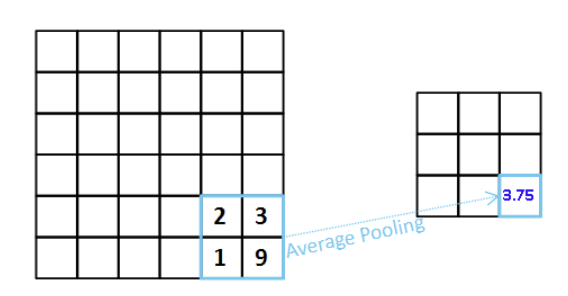

In [ ]:
tensor_image = torch.tensor(image, dtype=torch.float32)
tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)

# average_pooling 적용
avgpool_layer = nn.AvgPool2d(kernel_size=2)

feature_map = avgpool_layer(tensor_image)

print(f"Average_Pooling을 거친 shape: {feature_map.shape}")

Average_Pooling을 거친 shape: torch.Size([1, 3, 249, 174])


### CNN Architecture

CNN의 기본 구조는 Conv -> ReLU -> Pooling을 반복.

[CNN구조와 전이학습](https://pink371010.medium.com/cnn%EC%9D%98-%EA%B5%AC%EC%A1%B0-f0f49daa273c)

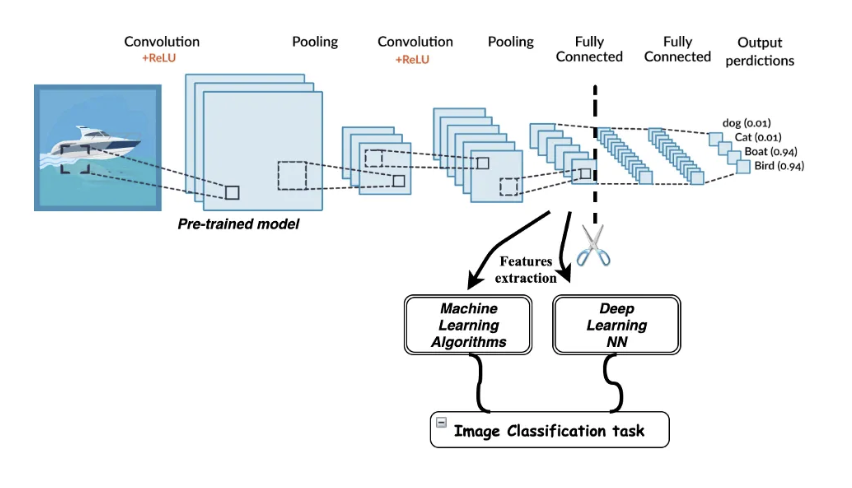

In [ ]:
# 모델 간단 구현
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=10, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(in_features=256*14*14, out_features=1000),
    nn.ReLU(),
    nn.Linear(in_features=1000, out_features=2),
)

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 10, 224, 224]         280
├─ReLU: 1-2                              [1, 10, 224, 224]         --
├─MaxPool2d: 1-3                         [1, 10, 112, 112]         --
├─Conv2d: 1-4                            [1, 64, 112, 112]         5,824
├─ReLU: 1-5                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-6                         [1, 64, 56, 56]           --
├─Conv2d: 1-7                            [1, 128, 56, 56]          73,856
├─ReLU: 1-8                              [1, 128, 56, 56]          --
├─MaxPool2d: 1-9                         [1, 128, 28, 28]          --
├─Conv2d: 1-10                           [1, 256, 28, 28]          295,168
├─ReLU: 1-11                             [1, 256, 28, 28]          --
├─MaxPool2d: 1-12                        [1, 256, 14, 14]          --
├─

# pytorch의 주요 학습 메커니즘

* device

* Dataset

* DataLoader

* loss_fn

* optimizer.zero_grad()

* loss.backward()

* optimizer.step()

* iteration(반복)

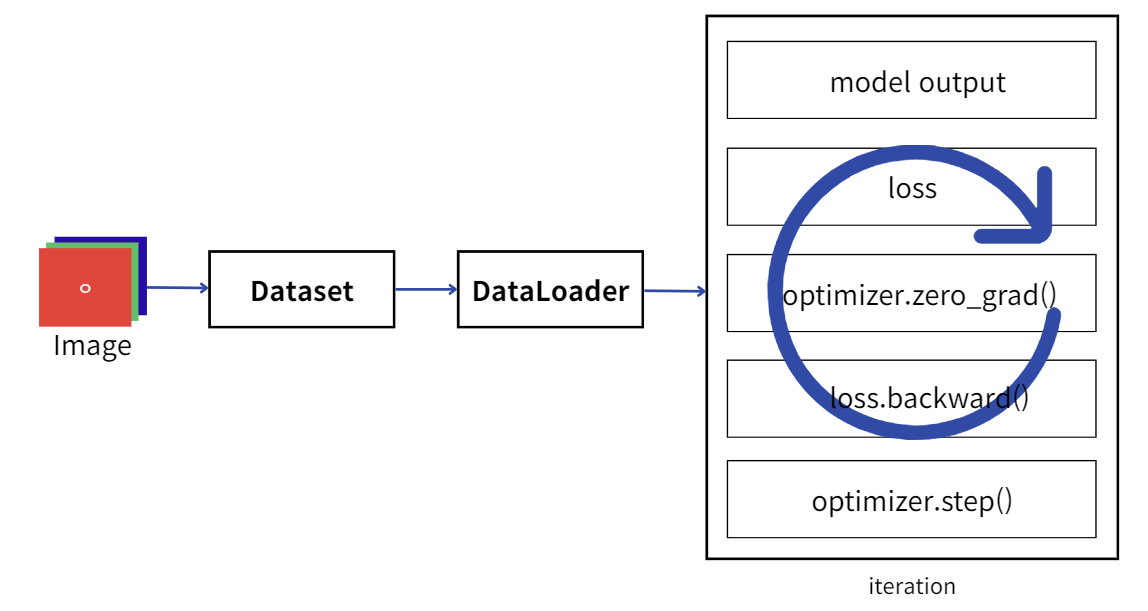

## device

pytorch에서는(사실 대부분의 딥러닝 프레임워크) 모델의 학습을 cpu와 gpu 측면에서 나눠서 관리함.<br/>

즉, 현재 해당하는 객체가 어디에 위치하는지 명시해줘야함.<br/>
model, image, label, metric 정도가 같은 곳에 위치해야함.<br/>

일반적으로 image augmentation은 cpu에서 모델의 학습은 gpu에서 작동함.

In [ ]:
import torch

# 현재 상황에서 cuda를 사용할 수 있는지 여부 확인(cpu에 연결되어 있으면 False, gpu가 있으면 True)
print(torch.cuda.is_available())

True


In [ ]:
# device 설정(cuda와 cpu 설정)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn

# pytorch의 model, image, label, metric 등에 .to(device)를 적용함.
model = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)

prev_model_device = next(model.parameters()).is_cuda

# 현재 cpu에 있는 model을 gpu에서 관리함.
model = model.to(device)

after_model_device = next(model.parameters()).is_cuda

# model 위치 보기
print(f"prev_model_device: {prev_model_device}")
print(f"after_model_device: {after_model_device}")

prev_model_device: False
after_model_device: True


## Dataset

pytorch에서는 Dataset이라는 클래스를 제공.<br/>
Dataset 클래스를 상속하면 \_\_init\_\_(), \_\_len\_\_(), \_\_getitem\_\_() 함수를 작성해야함.

* **\_\_init\_\_( )**: 객체 생성 시 입력받을 인자<br/>

* **\_\_len\_\_( )**: 전체 건수를 반환하는 값(일반적으로 filepath)<br/>

* **\_\_getitem\_\_( )**: index를 인자로 입력받아 실질적으로 모델이 학습시 모델에 데이터를 넘기는 함수<br/>

In [ ]:
from torch.utils.data import Dataset

# CNN Dataset
class Custom_Dataset(Dataset):
    # 여기서 transform은 albumentations transform이라고 가정.
    # 모든 image는 OpenCV로 다룸.
    # 따라서 마지막에 last channel -> first channel로 바꿔주는 로직이 별도로 필요.
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths # 이미지 경로를 담고 있는 array
        self.targets = targets # 해당 target을 담고 있는 array
        self.transform = transform # 이미지 augmentation하는 함수

    # 전체 건수 반환
    def __len__(self):
        return len(self.image_paths) # 이미지 건수가 1000건이라면, 1000 반환

    # 주요 메커니즘
    def __getitem__(self, idx):
        image_path = self.image_paths[idx] # 해당 index의 이미지 경로 가져오기
        # image는 ndarry.
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # 이미지 불러오기

        # albumentation 별도 적용.
        # albumentation에서 ToTensorV2를 별도로 적용.
        # 사실 이 로직이 작동하지 않으면 오류 발생.
        if self.transform is not None:
            image = self.transform(image=image)['image']

        if self.targets is not None:
            target = torch.tensor(self.targets[idx])
            return image, target
        else:
            return image

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    A.ToTensorV2(),
])

custom_dataset = Custom_Dataset(train_df["image_path"].values, train_df["label"].values, transform)

## DataLoader

Dataset 객체를 iterable하게 변형해주는 함수.

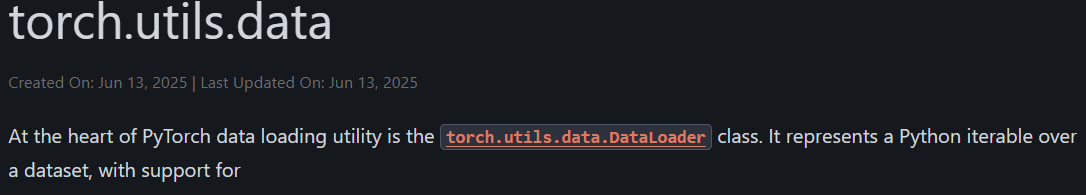

In [ ]:
from torch.utils.data import DataLoader

# DataLoader를 이용하여 Dataset 객체를 iterable하게 변경
custom_dataloader = DataLoader(custom_dataset, batch_size=16, shuffle=True, pin_memory=True)

In [ ]:
images, targets = next(iter(custom_dataloader))

print(f"images shape: {images.shape}")
print(f"targets shape: {targets.shape}")

images shape: torch.Size([16, 3, 224, 224])
targets shape: torch.Size([16])


In [ ]:
# dataloader 작동 원리
for images, targets in custom_dataloader:
    print(images.shape)
    print(targets.shape)
    print(targets)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16])
tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])


## loss_fn

In [ ]:
import torch.nn as nn

# 많이 쓰이는 Loss 함수
# 일반적으로 pytorch의 loss 함수는 인자로 predict와 target을 입력으로 받음.
loss_fn = nn.CrossEntropyLoss()

In [ ]:
pred = torch.tensor(
    [[1, 0], [0, 1]],
    dtype=torch.float32
)

targets = torch.tensor(
    [[0, 1], [0, 1]],
    dtype=torch.float32
)

loss = loss_fn(pred, targets)

## optimizer.zero_grad()

앞에서 계산된 gradient 값을 초기화 하는 함수

In [ ]:
from torch.nn import Sequential

# optimizer에는 model의 파라미터가 들어가야 하므로, CNN model을 간단하게 만듬.
model = Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(in_features=12544, out_features=1024),
    nn.Linear(in_features=1024, out_features=200),
    nn.Linear(in_features=200, out_features=2)
)

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 224, 224]         448
├─ReLU: 1-2                              [1, 16, 224, 224]         --
├─MaxPool2d: 1-3                         [1, 16, 112, 112]         --
├─Conv2d: 1-4                            [1, 32, 112, 112]         4,640
├─ReLU: 1-5                              [1, 32, 112, 112]         --
├─MaxPool2d: 1-6                         [1, 32, 56, 56]           --
├─Conv2d: 1-7                            [1, 64, 56, 56]           18,496
├─ReLU: 1-8                              [1, 64, 56, 56]           --
├─MaxPool2d: 1-9                         [1, 64, 28, 28]           --
├─Conv2d: 1-10                           [1, 128, 28, 28]          73,856
├─ReLU: 1-11                             [1, 128, 28, 28]          --
├─MaxPool2d: 1-12                        [1, 128, 14, 14]          --
├─C

In [ ]:
from torch.optim import Adam

# optimizer 객체 생성(보통 Adam이 많이 쓰임)
optim = Adam(model.parameters(), lr=0.0001)

In [ ]:
# optimizer의 gradient를 0으로 초기화
optim.zero_grad()

## loss.backward()

경사하강법을 이요해 gradient 계산

In [ ]:
import torch.nn as nn

# 많이 쓰이는 Loss 함수
# 일반적으로 pytorch의 loss 함수는 인자로 predict와 target을 입력으로 받음.
loss_fn = nn.CrossEntropyLoss()

In [ ]:
pred = torch.tensor(
    [[1, 0], [0, 1]],
    requires_grad=True, # 이거 없으면 backward가 실행 안됨!
    dtype=torch.float32
)

targets = torch.tensor(
    [[0, 1], [0, 1]],
    requires_grad=True,
    dtype=torch.float32
)

loss = loss_fn(pred, targets)

In [ ]:
# gradient 계산
loss.backward()

## optimizer.step()

실질적인 weight는 optimizer에서 업데이트를 진행.

In [ ]:
for parameter in model.parameters():
    print(parameter[0])
    break

tensor([[[-0.0805, -0.1335, -0.0236],
         [ 0.1917, -0.1042,  0.0058],
         [-0.0941,  0.1210,  0.1299]],

        [[-0.0079,  0.1500, -0.0288],
         [-0.1571,  0.1376,  0.0082],
         [ 0.1813,  0.0060, -0.1683]],

        [[ 0.1081, -0.0880,  0.1834],
         [ 0.1178,  0.0761,  0.0269],
         [-0.1186,  0.0196, -0.1586]]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [ ]:
# 이미지랑 target 불러오기
image, target = next(iter(custom_dataloader))

In [ ]:
model = model.to(device)
image = image.to(device)
target = target.to(device)

logit = model(image) # logit값 구하기(모델에서 나온 raw값)
softmax = nn.Softmax(dim=-1) # softamx 활성화 함수로 logit -> 확률로 변경
pred = softmax(logit) # pred값 구하기

In [ ]:
loss = loss_fn(pred, target) # loss값 구하기

In [ ]:
optim.zero_grad() # 기존 optimizer값 초기화
loss.backward() # gradient 구하기

In [ ]:
optim.step() # model의 가중치 업데이트

In [ ]:
# 새로운 가중치 확인
for parameter in model.parameters():
    print(parameter[0])
    break

tensor([[[-0.0804, -0.1334, -0.0235],
         [ 0.1918, -0.1041,  0.0059],
         [-0.0940,  0.1211,  0.1300]],

        [[-0.0078,  0.1501, -0.0287],
         [-0.1570,  0.1377,  0.0083],
         [ 0.1814,  0.0061, -0.1682]],

        [[ 0.1082, -0.0879,  0.1835],
         [ 0.1179,  0.0762,  0.0270],
         [-0.1185,  0.0197, -0.1585]]], device='cuda:0',
       grad_fn=<SelectBackward0>)


## iteration(반복)

이제 정말 다 배웠습니다.<br/>
앞에서 배운 과정을 계속 반복하면 모델을 학습시킬 수 있습니다.

In [ ]:
# Model 만들기
model = Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(in_features=12544, out_features=1024),
    nn.Linear(in_features=1024, out_features=200),
    nn.Linear(in_features=200, out_features=2)
)

In [ ]:
# Custom_Dataset 생성

train_dataset = Custom_Dataset(train_df["image_path"].values, train_df["label"].values, transform)
val_dataset = Custom_Dataset(val_df["image_path"].values, val_df["label"].values, transform)
test_dataset = Custom_Dataset(test_df["image_path"].values, None, transform)

In [ ]:
# Custom_DataLoader 생성

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, pin_memory=True)

In [ ]:
# 반복 로직 구현

optim = Adam(model.parameters(), lr=0.0001)
softmax = nn.Softmax(dim=-1)
loss_fn = nn.CrossEntropyLoss()

epochs = 3

model = model.to(device)

model.train()
for epoch in range(1, epochs+1):
    print(f"################ 현재 epoch: [{epoch}] ################")
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = softmax(logits)
        loss = loss_fn(preds, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch_idx % 20 == 0:
            print(f"현재 loss: {loss.item()}")

################ 현재 epoch: [1] ################
현재 loss: 0.5877518057823181
현재 loss: 0.6701153516769409
현재 loss: 0.5482583045959473
현재 loss: 0.4614494740962982
현재 loss: 0.4799029231071472
현재 loss: 0.5915186405181885
현재 loss: 0.5041780471801758
현재 loss: 0.5177419185638428
현재 loss: 0.470281720161438
현재 loss: 0.4961368441581726
현재 loss: 0.498435378074646
현재 loss: 0.4595041871070862
현재 loss: 0.4352051913738251
현재 loss: 0.5420083999633789
현재 loss: 0.5394371747970581
현재 loss: 0.5529597997665405
현재 loss: 0.49765413999557495
현재 loss: 0.5588060617446899
현재 loss: 0.5911071300506592
현재 loss: 0.49408167600631714
현재 loss: 0.49290934205055237
현재 loss: 0.43138548731803894
현재 loss: 0.5530681610107422
현재 loss: 0.41138941049575806
현재 loss: 0.6209298968315125
현재 loss: 0.49224695563316345
현재 loss: 0.5676802396774292
현재 loss: 0.4191253185272217
현재 loss: 0.4535139203071594
현재 loss: 0.5638779997825623
현재 loss: 0.4708707928657532
현재 loss: 0.5257747173309326
현재 loss: 0.5747907161712646
현재 loss: 0.5112612843513

In [ ]:
# 모델 예측

test_image = cv2.cvtColor(cv2.imread(test_df["image_path"].values[0]), cv2.COLOR_BGR2RGB) # 예측할 이미지
test_image = transform(image=test_image)['image'] # 리사이즈 + tensor로
test_image = test_image.unsqueeze(0) # 4차원으로 만들기
test_image = test_image.to(device)

model.eval()

# 학습된 모델로 예측
logit = model(test_image)
pred_proba = softmax(logit)

print(pred_proba)

tensor([[2.9143e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## 모델이 맞게 예측했는지 확인

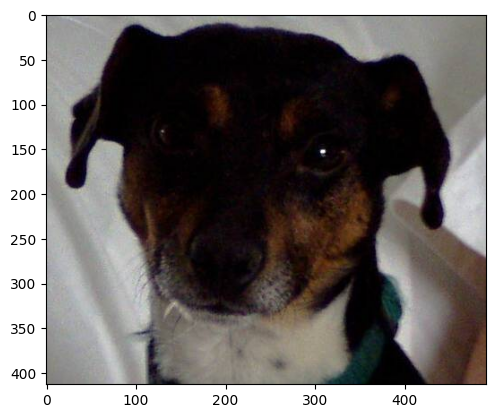

In [ ]:
image = cv2.cvtColor(cv2.imread(test_df["image_path"].values[0]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
pred = pred_proba.argmax(dim=-1)

In [ ]:
id_to_label[pred.item()]

'dog'